### Student Information
Name:林貫原

Student ID: 711233119

GitHub ID:GPLIN514

Kaggle name:GPLINCURRY

Kaggle private scoreboard snapshot:

![Alt text](rank.png)

This notebook is for Lab2 Kaggle competition. For further information, see [kaggle_competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework/overview).

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

## This time, the goal

1. Data Preprocessing: Added detailed text cleaning steps (stopword removal, special character filtering, etc.).
2. Model Architecture: Used a Bidirectional LSTM with dropout for better representation and regularization.
3. Training Process: Included validation split to monitor overfitting and improve generalization.
4. Prediction and Submission: Ensured predicted emotions are mapped back to their original labels and formatted for submission.

## ----------------------------
## **Data preparation**
## ----------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

/Users/gp/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Load the datasets
data_id = pd.read_csv("/Users/gp/Desktop/data-mining/DMLab2/DM2024-Lab2-Homework/dm-2024-isa-5810-lab-2-homework/data_identification.csv")
emotion = pd.read_csv("/Users/gp/Desktop/data-mining/DMLab2/DM2024-Lab2-Homework/dm-2024-isa-5810-lab-2-homework/emotion.csv")
tweets = pd.read_json("/Users/gp/Desktop/data-mining/DMLab2/DM2024-Lab2-Homework/dm-2024-isa-5810-lab-2-homework/tweets_DM.json", lines=True)

In [4]:
# Print tweets dataset structure for debugging
print (tweets)

         _score          _index  \
0           391  hashtag_tweets   
1           433  hashtag_tweets   
2           232  hashtag_tweets   
3           376  hashtag_tweets   
4           989  hashtag_tweets   
...         ...             ...   
1867530     827  hashtag_tweets   
1867531     368  hashtag_tweets   
1867532     498  hashtag_tweets   
1867533     840  hashtag_tweets   
1867534     360  hashtag_tweets   

                                                   _source  \
0        {'tweet': {'hashtags': ['Snapchat'], 'tweet_id...   
1        {'tweet': {'hashtags': ['freepress', 'TrumpLeg...   
2        {'tweet': {'hashtags': ['bibleverse'], 'tweet_...   
3        {'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...   
4        {'tweet': {'hashtags': [], 'tweet_id': '0x2de2...   
...                                                    ...   
1867530  {'tweet': {'hashtags': ['mixedfeeling', 'butim...   
1867531  {'tweet': {'hashtags': [], 'tweet_id': '0x29d0...   
1867532  {'tweet': {'

In [5]:
# Check and print shapes of the loaded datasets
print(data_id.shape) # Shape of identification dataset
data_id.head()

(1867535, 2)


,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


In [6]:
print(emotion.shape) # Shape of emotion dataset
emotion.head()

(1455563, 2)


,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [7]:
print(tweets.shape) # Shape of tweets dataset
tweets.head()

(1867535, 5)


,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [8]:
# Extract tweet_id and text from '_source' column
tweet_data = pd.DataFrame([
    {
        "tweet_id": tweet['_source']['tweet']['tweet_id'],
        "text": tweet['_source']['tweet']['text']
    }
    for _, tweet in tweets.iterrows()
])

In [9]:
tweet_data.head()

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."


In [11]:
len(tweet_data['tweet_id'])

1867535

In [12]:
# Merge datasets
df = data_id.merge(emotion, on='tweet_id', how='outer').merge(tweet_data, on='tweet_id', how='outer')

# Display merged DataFrame shape
print(df.shape)

(1867535, 4)


In [13]:
df.head()

,tweet_id,identification,emotion,text
0,0x1c7f0f,test,NaN,"@JZED74 While inappropriate AF, he likely wasn..."
1,0x1c7f10,train,joy,o m g Shut Up And Dance though #BlackMirror <LH>
2,0x1c7f11,train,anticipation,On #twitch <LH> on the #Destinybeta #Destiny #...
3,0x1c7f12,test,NaN,I tried to figure out why you mean so much to ...
4,0x1c7f13,test,NaN,"The only “big plan” you ever had in your life,..."


In [15]:
# Split into train and test sets
train_df = df[df['identification'] == 'train']
test_df = df[df['identification'] == 'test']

In [17]:
len(test_df.emotion) - sum(test_df.emotion.isnull())

0

## ----------------------------
## **Preprocessing**
## ----------------------------

Clean the text data by removing unwanted elements like URLs, mentions, and special characters. Stopwords are also removed to reduce noise.

In [ ]:
def clean_text(text):
    """
    Cleans text by:
    - Removing URLs, mentions, and special characters
    - Lowercasing and stripping extra whitespace
    - Removing stopwords
    """
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtags but keep the word
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Lowercase and strip whitespace
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

In [ ]:
# Apply text cleaning to training and testing datasets
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

/var/folders/06/lhq2f9c955x9yv48ck4tyhfm0000gn/T/ipykernel_1014/473475732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cleaned_text'] = train_df['text'].apply(clean_text)
/var/folders/06/lhq2f9c955x9yv48ck4tyhfm0000gn/T/ipykernel_1014/473475732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cleaned_text'] = test_df['text'].apply(clean_text)


In [20]:
print(train_df.shape)
print(train_df)
print(test_df.shape)
print(test_df.shape[0]/(test_df.shape[0]+train_df.shape[0]))

(1455563, 5)
         tweet_id identification       emotion  \
1        0x1c7f10          train           joy   
2        0x1c7f11          train  anticipation   
5        0x1c7f14          train           joy   
6        0x1c7f15          train           joy   
7        0x1c7f16          train       disgust   
...           ...            ...           ...   
1867529  0x38fe18          train       sadness   
1867530  0x38fe19          train  anticipation   
1867531  0x38fe1a          train      surprise   
1867533  0x38fe1c          train       disgust   
1867534  0x38fe1d          train       sadness   

                                                      text  \
1         o m g Shut Up And Dance though #BlackMirror <LH>   
2        On #twitch <LH> on the #Destinybeta #Destiny #...   
5        A nice sunny wak this morning not many <LH> ar...   
6        I'm one of those people who love candy corn......   
7        @metmuseum What are these? They look like some...   
...           

## ----------------------------
## **EDA**
## ----------------------------

In [22]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

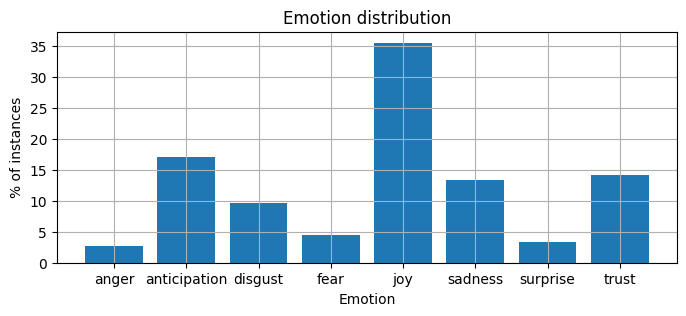

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## ----------------------------
## **Tokenization and Sequence Padding**
## ----------------------------

Convert the cleaned text data into sequences of integers using the Keras Tokenizer. Pad all sequences to the same length for compatibility with the model.

In [ ]:
# Tokenizer initialization
# Initialize tokenizer with a vocabulary size of 10,000
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

In [25]:
# Convert texts to padded sequences
def get_sequences(tokenizer, texts, maxlen=50):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_sequences

In [26]:
# Pad sequences to a fixed length
padded_train_sequences = get_sequences(tokenizer, train_df['cleaned_text'])
padded_test_sequences = get_sequences(tokenizer, test_df['cleaned_text'])

In [30]:
padded_train_sequences[10]

array([ 547, 1632,    1, 1357,  241, 1331,    2,  299,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## ----------------------------
## **Label Encoding**
## ----------------------------

In [27]:
# Convert emotion labels to numerical format
classes = sorted(train_df['emotion'].dropna().unique())  # Ensure consistent class order
class_to_index = {label: i for i, label in enumerate(classes)}
index_to_class = {i: label for label, i in class_to_index.items()}

# Convert labels to numerical format
train_labels = train_df['emotion'].map(class_to_index).values
test_labels = test_df['emotion'].map(class_to_index).fillna(-1).values  # Use -1 for missing test labels

## ----------------------------
## **Model Definition**
## ----------------------------

Define a Bidirectional LSTM model with embedding, dropout, and dense layers. The model is compiled using sparse categorical crossentropy and the Adam optimizer.

In [28]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 128, input_length=50),  # Larger embedding dimension for richer representation
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),  # Dropout to reduce overfitting
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

/Users/gp/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Reduced learning rate for stability
    metrics=['accuracy']
)

In [29]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## ----------------------------
## **Model Training**
## ----------------------------

Train the model on the training data while validating on a split of the training set.

In [31]:
# Train-test split for validation during training
X_train, X_val, y_train, y_val = train_test_split(padded_train_sequences, train_labels, test_size=0.2, random_state=42)

In [23]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,  # Increased epochs for better learning
    batch_size=32,
    verbose=1
)

Epoch 1/5
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 3957s 109ms/step - accuracy: 0.4522 - loss: 1.5015 - val_accuracy: 0.5199 - val_loss: 1.3229
Epoch 2/5
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 3679s 101ms/step - accuracy: 0.5287 - loss: 1.3039 - val_accuracy: 0.5336 - val_loss: 1.2823
Epoch 3/5
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 2267s 62ms/step - accuracy: 0.5438 - loss: 1.2585 - val_accuracy: 0.5383 - val_loss: 1.2662
Epoch 4/5
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 2799s 77ms/step - accuracy: 0.5522 - loss: 1.2345 - val_accuracy: 0.5425 - val_loss: 1.2551
Epoch 5/5
36390/36390 ━━━━━━━━━━━━━━━━━━━━ 26906s 739ms/step - accuracy: 0.5594 - loss: 1.2135 - val_accuracy: 0.5445 - val_loss: 1.2506


## ----------------------------
## **Evaluation and Prediction**
## ----------------------------

Use the trained model to predict emotions for the test set. Convert numerical predictions back to emotion labels and save the results as a CSV file for submission.

In [24]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.2f}")

9098/9098 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - accuracy: 0.5438 - loss: 1.2507
Validation Accuracy: 0.54


In [25]:
# Predict on test data
predictions = model.predict(padded_test_sequences)  # Get probability scores for each class
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
predicted_labels.shape, predictions.shape

12875/12875 ━━━━━━━━━━━━━━━━━━━━ 325s 25ms/step


((411972,), (411972, 8))

In [26]:
# Map numerical predictions back to emotion labels
predicted_emotions = [index_to_class[idx] for idx in predicted_labels]

In [27]:
# Create a Pandas DataFrame for submission
submission = pd.DataFrame({
    'id': test_df['tweet_id'],  # Use 'tweet_id' as 'id'
    'emotion': predicted_emotions  # Predicted emotion labels
})

In [ ]:
# Save predictions to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission1.csv'


<hr>